In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
pd.options.display.float_format = '{:.5f}'.format

군집화를 위한 bigcon_train_origin과 log_data csv 호출

In [3]:
train = pd.read_csv("/content/drive/MyDrive/빅콘테스트/bigcon_train_origin.csv", index_col = 0)

In [4]:
log_data = pd.read_csv("/content/drive/MyDrive/빅콘테스트/빅콘테스트_데이터셋/log_data.csv")

## bank_rank 파생변수 생성

is_applied가 1인 데이터 중 bank_id의 개수가 제일 많은 순서대로 그룹화하여 순위를 결정한 뒤 bank_rank 변수 생성

In [5]:
train['bank_rank'] = 0

In [6]:
bank_list = [59, 29, 49, 38]

for i in bank_list:
    idx = train[train['bank_id'].isin([i])]['bank_id'].index
    train.loc[idx,'bank_rank'] = 6

In [7]:
bank_list = [2, 35, 27, 1, 36]

for i in bank_list:
    idx = train[train['bank_id'].isin([i])]['bank_id'].index
    train.loc[idx,'bank_rank'] = 5

In [8]:
bank_list = [4, 33, 6, 40, 8, 63, 50, 13, 19, 21, 23, 30, 47, 52]

for i in bank_list:
    idx = train[train['bank_id'].isin([i])]['bank_id'].index
    train.loc[idx,'bank_rank'] = 4

In [9]:
bank_list = [58, 10, 54, 22, 32, 17, 5, 31, 43, 45, 7, 37]

for i in bank_list:
    idx = train[train['bank_id'].isin([i])]['bank_id'].index
    train.loc[idx,'bank_rank'] = 3

In [10]:
bank_list = [14, 56, 41, 42, 15, 24, 34,57, 44, 60, 11, 25, 55, 2, 64, 18, 3, 26, 20, 46, 51, 12]

for i in bank_list:
    idx = train[train['bank_id'].isin([i])]['bank_id'].index
    train.loc[idx,'bank_rank'] = 2

In [11]:
bank_list = [61, 39, 9, 28, 16]

for i in bank_list:
    idx = train[train['bank_id'].isin([i])]['bank_id'].index
    train.loc[idx,'bank_rank'] = 1

## train_event 생성

log_data의 event칼럼의 행동명들의 횟수를 칼럼으로 변환

In [12]:
df = log_data[['user_id','event']].value_counts().to_frame()

In [13]:
df.reset_index(inplace=True)

In [14]:
df.rename(columns = {0: 'count'}, inplace=True)

In [15]:
event = ['SignUp','OpenApp','Login','ViewLoanApplyIntro','StartLoanApply','CompleteIDCertification',
         'EndLoanApply','UseLoanManage','UsePrepayCalc','UseDSRCalc','GetCreditInfo']

for i in event:
    df_new = df[df['event']==i]
    df_new.drop(['event'], axis= 1, inplace=True)
    train = pd.merge(train,df_new, how = 'outer') 
    train.rename(columns = {"count": i}, inplace = True)

In [16]:
train.dropna(axis=0, subset=['application_id'], inplace= True)

In [17]:
for i in event:
    train[i].fillna(0, inplace=True)

## 이상치 처리

In [18]:
# 승인 한도가 99억 이상인 값 제거
idx = train[train['loan_limit']>9900000000].index
train.drop(idx, axis=0, inplace=True)
train.reset_index(drop=True, inplace =True)

IQR 기준 이상치 제거

In [19]:
def get_outlier(df=None, column=None, weight=1.5):
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

# 함수 사용해서 이상치 값 삭제
outlier_list = ['yearly_income','desired_amount','loan_limit','Login','EndLoanApply','UseLoanManage','UsePrepayCalc','UseDSRCalc','GetCreditInfo']

for i in outlier_list:
    oulier_idx = get_outlier(df=train, column=i, weight=1.5)
    train.drop(oulier_idx, axis=0, inplace=True)

In [20]:
train.reset_index(drop=True, inplace =True)

## 생년월일 -> 나이로 변환

In [21]:
train['age'] = 2022 - train['birth_year'] + 1
train.drop('birth_year', axis = 1, inplace = True)

## 인코딩

In [22]:
# 범주형 변수들 LabelEncoding 
features = ['income_type', 'employment_type', 'houseown_type', 'purpose']

for o_col in features:
    encoder = LabelEncoder()
    encoder.fit(train[o_col])       
    train_encoded = encoder.transform(train[o_col])

    train[o_col] = train_encoded

## 불필요한 칼럼 삭제


company_enter_month : 데이터의 신뢰성이 낮아 제거

In [23]:
train.drop(['SignUp','OpenApp','ViewLoanApplyIntro','StartLoanApply','CompleteIDCertification',
            'insert_time', 'loanapply_insert_time','company_enter_month','gender','personal_rehabilitation_complete_yn',
            'personal_rehabilitation_yn'], axis= 1, inplace=True)

## 결측치 처리

In [24]:
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i,col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col +=1
            print('결측치가 있는 칼럼은: %s 입니다.'%col)
            print('해당 칼럼에 총 %s개의 결측치가 존재합니다. '%missing_values)
            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다.')
    return missing_col

In [25]:
missing_col = check_missing_col(train)

결측치가 있는 칼럼은: credit_score 입니다.
해당 칼럼에 총 1023104개의 결측치가 존재합니다. 
결측치가 있는 칼럼은: existing_loan_cnt 입니다.
해당 칼럼에 총 1707913개의 결측치가 존재합니다. 
결측치가 있는 칼럼은: existing_loan_amt 입니다.
해당 칼럼에 총 2224116개의 결측치가 존재합니다. 
결측치가 있는 칼럼은: loan_limit 입니다.
해당 칼럼에 총 3793개의 결측치가 존재합니다. 
결측치가 있는 칼럼은: loan_rate 입니다.
해당 칼럼에 총 3793개의 결측치가 존재합니다. 
결측치가 있는 칼럼은: age 입니다.
해당 칼럼에 총 70142개의 결측치가 존재합니다. 


existing_loan_cnt -> 0이 없기 때문에 기대출이 없다고 판단하여 0으로 채워줌


In [26]:
train['existing_loan_cnt'].fillna(0, inplace= True)

existing_loan_amt -> 기대출수가 결측치이면 -> 기대출금액도 결측치 -> 따라서 0,    나머지 900292개의 결측치는 -> IterativeImputer


In [27]:
idx2 = train[train['existing_loan_cnt']==0].index
train.loc[idx2,'existing_loan_amt'] = 0

loan_rate, loan_limit 컬럼에 결측치(nan)가 있는 경우는 금융사에서 값을 보내주지 않은 경우로,  해당 경우는 채점에서 제외할 예정이니 제거



In [28]:
train['loan_limit'].dropna(axis=0, inplace=True)
train['loan_rate'].dropna(axis=0, inplace=True)

insert_time, loanapply_insert_time은 불필요하다 판단하여 제거.

## admission_count 파생변수 생성

In [29]:
train.reset_index(drop=True, inplace=True)

In [30]:
train_sort = train.sort_values('application_id')

In [31]:
admission_count_train = pd.DataFrame(train['application_id'].value_counts().sort_index())

In [32]:
admission_count_train.columns = ['admission_count']

In [33]:
admission_count_train.index.name = 'application_id'

In [34]:
admission_count_train = admission_count_train.reset_index()

In [35]:
train = pd.merge(train_sort, admission_count_train)

## IterativeImputer를 이용해 결측치 채우기

credit_score 결측치 채우기

In [36]:
# credit score랑 상관계수가 0.2 이상인 변수만 추출
train_miss = train[['desired_amount', 'existing_loan_cnt', 'loan_limit', 'loan_rate', 'admission_count', 'credit_score']]

In [37]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(random_state=42)

train_trans = imputer.fit_transform(train_miss)
train_miss = pd.DataFrame(train_trans, columns=train_miss.columns)

In [38]:
train['credit_score']= train_miss['credit_score']

train의 나머지 결측치 행 제거

In [39]:
train.dropna(axis = 0, inplace = True)

In [40]:
train.reset_index(drop=True, inplace=True)

## credit_loan_rate 파생변수 생성

여신금융협회 데이터에서 신용점수 별 대출금리의 평균을 구한 뒤 각 신용점수 구간에 해당하는 lona_rate와 비교하여 loan_rate가 더 높을 경우 0, 낮을 경우 1의 값을 할당

In [41]:
train['credit_loan_rate']= 1

In [42]:
score300 = (16.99+18.45)/2
score400 = 19.9
score500 = (19.18+19.9+19.9)/3
score600 = (19.9+14.37+18.27+15.78+17.9+17.57+14.65+19.13+10.9+18.5+16.86+18.79)/12
score700 = (19.59+14.29+16.71+14.89+14.53+16.81+14.14+18.74+12.25+18.25+16.12+16.12)/12
score800 = (16.18+11.71+13.03+15.57+13.59+13.02+15.58+12.82+17.53+11.65+17.55+14.68+14.26)/13
score900 = (13.90+11.87+10.7+14.54+12.69+12.75+13.51+11.83+15.75+10.71+15.53+12.89+12.75)/13
score1000 = (12.62+11.26+9.28+13.05+12.22+10.45+11.29+10.60+12.21+10.25+12.92+11.43+11.50)/13

In [43]:
cond1 = (train['credit_score'] <= 300) & (train['loan_rate'] > score300)
cond2 = (train['credit_score'] > 300) & (train['credit_score'] <= 400) & (train['loan_rate'] > score400)
cond3 = (train['credit_score'] > 400) & (train['credit_score'] <= 500) & (train['loan_rate'] > score500)
cond4 = (train['credit_score'] > 500) & (train['credit_score'] <= 600) & (train['loan_rate'] > score600)
cond5 = (train['credit_score'] > 600) & (train['credit_score'] <= 700) & (train['loan_rate'] > score700)
cond6 = (train['credit_score'] > 700) & (train['credit_score'] <= 800) & (train['loan_rate'] > score800)
cond7 = (train['credit_score'] > 800) & (train['credit_score'] <= 900) & (train['loan_rate'] > score900)
cond8 = (train['credit_score'] > 900) & (train['loan_rate'] > score1000)

In [44]:
train['credit_loan_rate'] = np.where(cond1,0,np.where(cond2,0,np.where(cond3,0,np.where(cond4,0,np.where(cond5,0,np.where(cond6,0,np.where(cond7,0,np.where(cond8,0,1))))))))

## age를 범주화하여 age_level 생성

모든 기준은 대한민국 평균 연령로 결정  
1) 평균 취업 연령 : 28세  
2) 평균 결혼 및 출산 연령 : 32세  
3) 평균 내 집 마련 연령 : 40세  
4) 평균 은퇴 연령 : 60세   
를 이용해 age를 범주화하여 age_level 생성

In [45]:
condition1 = (train['age'] < 28)
condition2 = (train['age'] >= 28) & (train['age'] < 32)
condition3 = (train['age'] >= 32) & (train['age'] < 40)
condition4 = (train['age'] >= 40) & (train['age'] < 60)
condition5 = (train['age'] >= 60)

In [46]:
train['age_level'] = np.where(condition1, 0, np.where(condition2,1,np.where(condition3,2,np.where(condition4,3,np.where(condition5,4,"NaN")))))

In [47]:
train['age_level'] = pd.to_numeric(train['age_level'])

In [48]:
train.drop(['age'],axis= 1, inplace=True)

## over_desired 파생변수 생성

In [49]:
condition_tr =((train['desired_amount'] - train['loan_limit']) >=0)
train['over_desired']=np.where(condition_tr,0,1)

In [50]:
train['over_desired'].value_counts()

0    3703910
1    2464659
Name: over_desired, dtype: int64

# --------군집화 추가 전처리--------

## 데이터 application_id당 하나로 정리

In [51]:
train = train.sort_values(by=["user_id"], ascending=[True])
train.reset_index(drop = True, inplace = True)

In [52]:
train = train.sort_values('is_applied', ascending = False)

In [53]:
train = train.drop_duplicates(['application_id']) 

In [54]:
train.reset_index(drop=True, inplace =True)

## service_dummy 생성 후 이상치 처리

In [55]:
train['service_dummy'] = train['UseLoanManage'] + train['UsePrepayCalc'] + train['UseDSRCalc'] + train['GetCreditInfo']

In [56]:
def get_outlier(df=None, column=None, weight=1.5):
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

# 함수 사용해서 이상치 값 삭제
outlier_list = ['service_dummy']

for i in outlier_list:
    oulier_idx = get_outlier(df=train, column=i, weight=1.5)
    train.drop(oulier_idx, axis=0, inplace=True)

In [57]:
train.reset_index(drop=True, inplace =True)

## 군집화 변수선택

In [58]:
train_copy = train.copy()

In [59]:
train_1 = train_copy[train_copy['is_applied'] == 1]

In [60]:
train_1.reset_index(drop=True, inplace=True)

In [61]:
train_1_copy = train_1.copy()

In [62]:
train_1_copy = train_1_copy[['loan_limit','loan_rate','admission_count','credit_score','age_level','yearly_income','service_dummy','existing_loan_amt']]
train_1_copy = train_1_copy

<!--  -->

## PCA 하기 전 스케일링

In [63]:
scale_columns = ['credit_score','yearly_income','loan_limit', 'existing_loan_amt']

for i in scale_columns:
    train_1_copy[i] = np.log1p(train_1_copy[i])

## PCA

In [64]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit(train_1_copy)
train_1_copy = pd.DataFrame(data = pca.transform(train_1_copy), columns=['pc1', 'pc2'])
train_1_copy

,pc1,pc2
0,31.29242,12.48673
1,-13.25800,8.12314
2,-7.96320,5.34569
3,-12.60185,4.84097
4,-10.92612,7.68581
...,...,...
224039,-9.30764,-15.06103
224040,-1.11067,3.62227
224041,-1.27314,-1.78504
224042,-2.71475,-14.74983


## Elbow Point

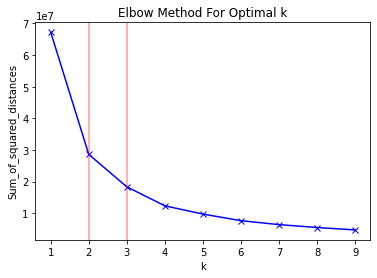

In [65]:
from sklearn.cluster import KMeans

sum_of_squared_distances = []
K = range(1, 10)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(train_1_copy)
    sum_of_squared_distances.append(km.inertia_)
    
# 시각화

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.axvline(2,c= 'r',alpha =0.4)
plt.axvline(3,c= 'r',alpha =0.4)
plt.show()

실루엣 계수

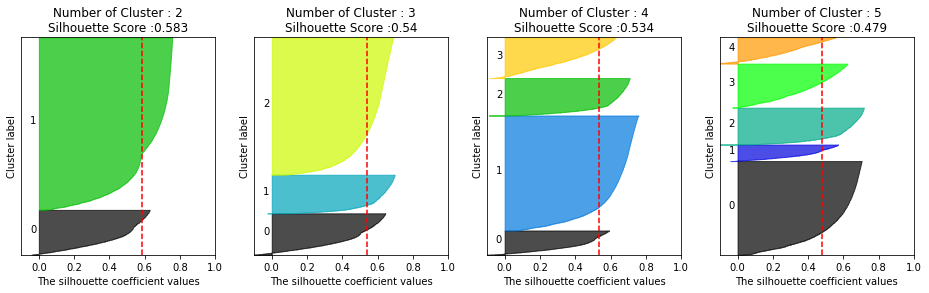

In [66]:
def visualize_silhouette(cluster_lists, X_features):     
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
   
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
   
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
   
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
       
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
       
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

            
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
       
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
           
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

           
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")


# cluster 개수를 2개, 3개, 4개, 5개 일때의 클러스터별 실루엣 계수 평균값을 시각화 
visualize_silhouette([ 2, 3, 4, 5], train_1_copy)

## Kmeans

In [67]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(train_1_copy)

train_1_copy['labels'] = kmeans.predict(train_1_copy)

## 군집화 결과 시각화

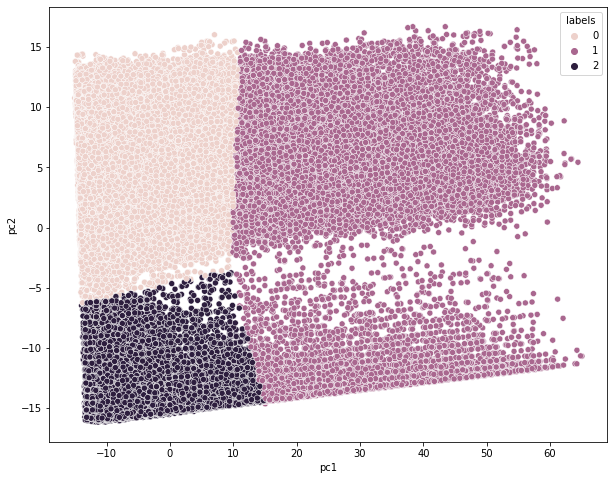

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
sns.scatterplot(x='pc1', y='pc2', hue='labels', data=train_1_copy)

## 대출 신청 한 고객 군집화, (is_applied ==1)

In [69]:
df_concat1 = pd.concat([train_1, train_1_copy['labels']], axis = 1)

In [70]:
df_concat1.groupby('labels').count() 

,application_id,user_id,credit_score,yearly_income,income_type,employment_type,houseown_type,desired_amount,purpose,existing_loan_cnt,...,EndLoanApply,UseLoanManage,UsePrepayCalc,UseDSRCalc,GetCreditInfo,admission_count,credit_loan_rate,age_level,over_desired,service_dummy
labels,,,,,,,,,,,,,,,,,,,,,
0,141517,141517,141517,141517,141517,141517,141517,141517,141517,141517,...,141517,141517,141517,141517,141517,141517,141517,141517,141517,141517
1,42780,42780,42780,42780,42780,42780,42780,42780,42780,42780,...,42780,42780,42780,42780,42780,42780,42780,42780,42780,42780
2,39747,39747,39747,39747,39747,39747,39747,39747,39747,39747,...,39747,39747,39747,39747,39747,39747,39747,39747,39747,39747


In [71]:
grouped_admission_count = df_concat1['admission_count'].groupby(df_concat1['labels'])
grouped_admission_count.mean()

grouped_admission_count = pd.DataFrame(grouped_admission_count.mean())

In [72]:
grouped_admission_count # 승인 상품 개수

,admission_count
labels,
0,7.26494
1,40.39303
2,8.33454


In [73]:
grouped = df_concat1['credit_score'].groupby(df_concat1['labels'])
grouped.mean()

labels
0   636.00611
1   768.42207
2   663.50173
Name: credit_score, dtype: float64

In [74]:
df_concat1.groupby("labels")['existing_loan_amt'].mean()

labels
0   65319488.11804
1   52661430.57504
2          0.00000
Name: existing_loan_amt, dtype: float64

In [75]:
df_concat1.groupby("labels")['existing_loan_cnt'].mean()

labels
0   5.10865
1   2.80159
2   0.01364
Name: existing_loan_cnt, dtype: float64

In [76]:
df_concat1.groupby("labels")['service_dummy'].mean()

labels
0   8.67782
1   6.41585
2   1.61260
Name: service_dummy, dtype: float64

## 대출 신청 안한 군집 (is_applied ==0)

In [77]:
train_0 = train[train['is_applied'] ==0]

In [78]:
train_0.reset_index(drop = True, inplace = True)

In [79]:
train_0['admission_count'].mean()

17.0409277635961

In [80]:
train_0['credit_score'].mean()

699.3034889214724

In [81]:
train_0['existing_loan_amt'].mean()

56381519.11145673

In [82]:
train_0['existing_loan_cnt'].mean()

3.3700911196389023

In [83]:
train_0['service_dummy'].mean()

6.917321747558591